# **TASK2, Bi-dimensional signal processing**

The Skin Cancer MNIST: HAM10000 dataset is a collection of skin lesion images for classification tasks, aimed at detecting various types of skin cancer. It contains over 10,000 high-quality images, each labeled with the type of lesion, such as melanoma, basal cell carcinoma, and others.
The dataset is available and downloadable at the attached link: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000 .


There are 7 different classes of skin lesions in the HAM10000 dataset. Here are the specific labels:

*   **akiec** - Actinic keratosis/Bowen's disease; (squamous   intraepithelial lesions)
*   **bcc** - Basal cell carcinoma;
*   **bkl** - Seborrheic keratosis / Solar keratosis;
*   **df** - Dermatofibroma;
*   **mel** - Melanoma;
*   **nv** - Melanocytic nevus;
*   **vasc** - Vascular lesions;

## **Setting up the environment, loading and exploring the data**

In [ ]:
# Importing libraries useful for the project
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, exposure
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
from zipfile import ZipFile
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import filters, feature, color, exposure
import albumentations as A

In [ ]:
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracts the ZIP file containing skin cancer images and organizes them into
# class-specific directories based on metadata labels.

# ZIP file path and destination folder
zip_path = '/content/drive/MyDrive/Digital Signal and Image Management/archive (1).zip'
extract_path = '/content/dataset/'

# Extracting the ZIP file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

metadata = pd.read_csv('/content/dataset/HAM10000_metadata.csv')

# A folder is created for each class label from the metadata (dx column).
classes = metadata['dx'].unique()
for classe in classes:
   os.makedirs(f'/content/dataset/organized/{classe}', exist_ok=True)

#  For each image ID, it checks the two parts of the dataset for the image,
#  then copies it to the respective class folder.
for index, row in metadata.iterrows():
   img_id = row['image_id']
   classe = row['dx']

# Search for the image in part_1 or part_2
   if os.path.exists(f'/content/dataset/HAM10000_images_part_1/{img_id}.jpg'):
       src = f'/content/dataset/HAM10000_images_part_1/{img_id}.jpg'
   else:
       src = f'/content/dataset/HAM10000_images_part_2/{img_id}.jpg'

   dst = f'/content/dataset/organized/{classe}/{img_id}.jpg'

   # Copy the image
   img = Image.open(src)
   img.save(dst)

At the end of this code, the images from the ZIP file are extracted and organized into directories based on their class labels. Each class folder contains images corresponding to the respective label from the metadata.

Now i have a structured dataset with images organized into categories like "melanoma", "basal cell carcinoma", etc., ready for further preprocessing.

In [ ]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Inspect the contents of the metadata DataFrame: it  contain information like the image IDs, lesion types (dx), patient data, and other features related to the skin lesions.

Now we are going to do a check on the images in each folder, we will print an image for each type of skin lesion on the screen.

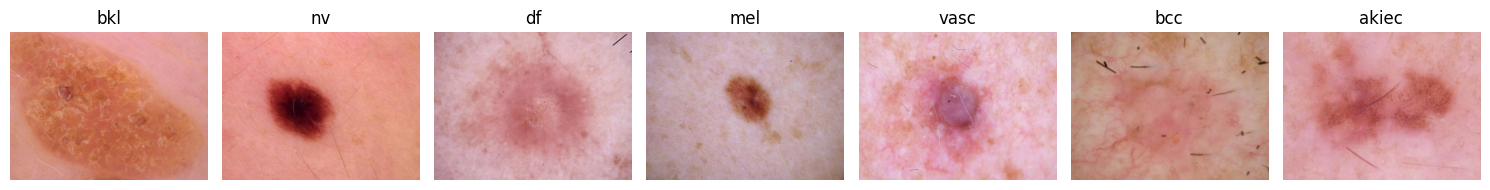

In [ ]:
# Extract unique classes from the dataset
classi = metadata['dx'].unique()

# Create a figure to display images
plt.figure(figsize=(15, 3))

# Cycle on each class
for i, classe in enumerate(classi):
    # Get a list of all images in the class folder
    img_files = os.listdir(f'/content/dataset/organized/{classe}')
    random_img = random.choice(img_files)
    # Construct the complete path to the image
    img_path = f'/content/dataset/organized/{classe}/{random_img}'
    plt.subplot(1, len(classi), i + 1)
    plt.imshow(plt.imread(img_path)) # load and show the image
    plt.title(classe) # title is the class
    plt.axis('off')

plt.tight_layout()
plt.show()

Visualizing a random image from each class is useful for a Dataset Overview and a Data Exploration.

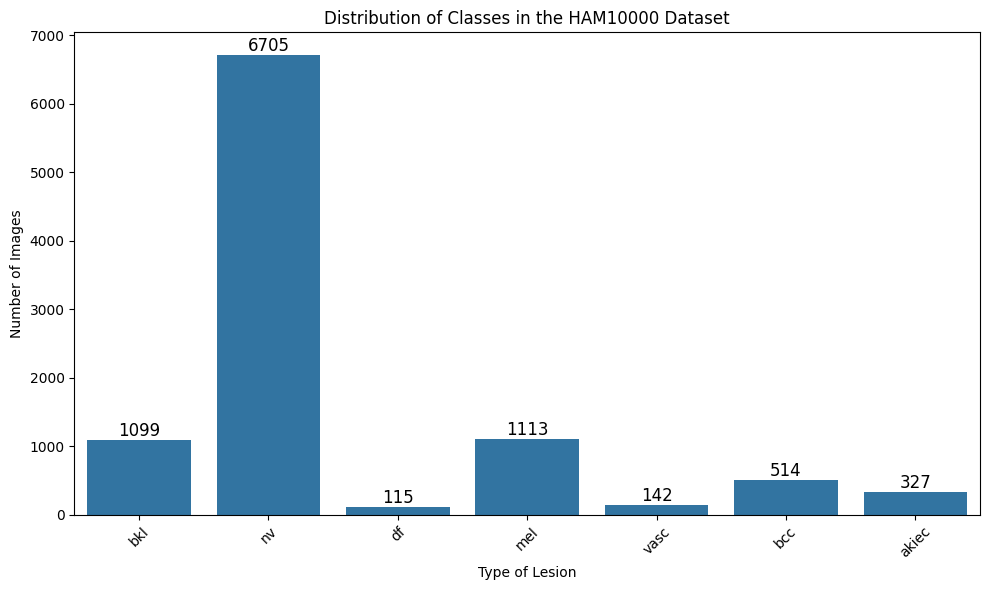

In [ ]:
# Visualising the distribution of skin lesion types in the dataset by creating a bar graph.
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=metadata, x='dx')

# Count of imagage for every class, on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(),
            f'{int(p.get_height())}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.title('Distribution of Classes in the HAM10000 Dataset')
plt.xlabel('Type of Lesion')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

The class "nv" (nevi), has almost 7,000 images while other classes like "bkl" (benign keratosis) and "mel" (melanoma) have only around 1,000 (and they are the more frequent after "nv" class), this suggests a **class imbalance**. The model might become biased toward predicting the most frequent class (nv), as it has much more data. Techniques such as resampling (oversampling underrepresented classes or undersampling dominant ones), class weights, or using balanced metrics should be considered to handle this imbalance during training.

Due to the high imbalance of the dataset and the large number of observations, only the 4 most numerous labels (nv, bkl, mel, bcc) were selected for computation purposes.

## **Image Preprocessing**

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# select relevant labels
selected_classes = {"nv", "bkl", "mel", "bcc"}

organized_dir = '/content/dataset/organized/'

# List fot image and label
images = []
labels = []

for class_name in os.listdir(organized_dir):
    class_path = os.path.join(organized_dir, class_name)

    if os.path.isdir(class_path) and class_name in selected_classes:

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)

            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

Caricamento classe mel...
Caricamento classe bcc...
Caricamento classe bkl...
Caricamento classe nv...


## **Image enhancement**

In [ ]:
enhanced_images = []
for image in images:

    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)

    lab_enhanced = cv2.merge([l_enhanced, a, b])

    enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)
    enhanced_images.append(enhanced)

enhanced_images = np.array(enhanced_images)

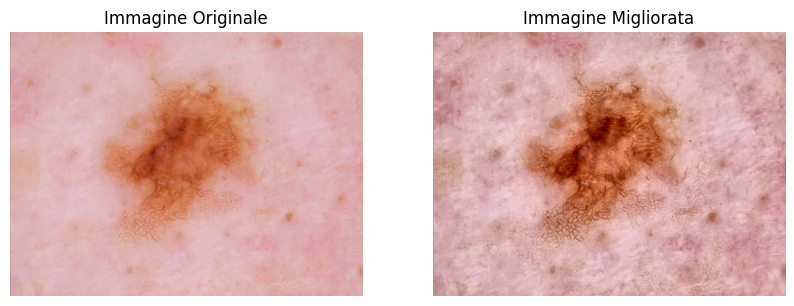

In [ ]:
image = cv2.imread('/content/dataset/organized/mel/ISIC_0026105.jpg') # Path for the interested class
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_enhanced = clahe.apply(l)

lab_enhanced = cv2.merge([l_enhanced, a, b])

enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(10, 5))

# original image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Immagine Originale")
plt.axis("off")

# enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Immagine Migliorata")
plt.axis("off")

plt.show()

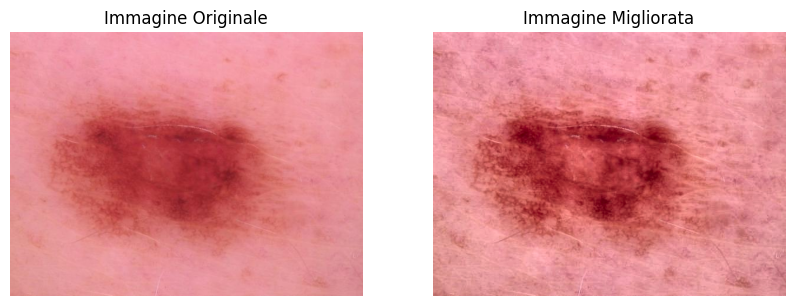

In [ ]:

image = cv2.imread('/content/dataset/organized/nv/ISIC_0029748.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_enhanced = clahe.apply(l)


lab_enhanced = cv2.merge([l_enhanced, a, b])

enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Immagine Originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Immagine Migliorata")
plt.axis("off")

plt.show()

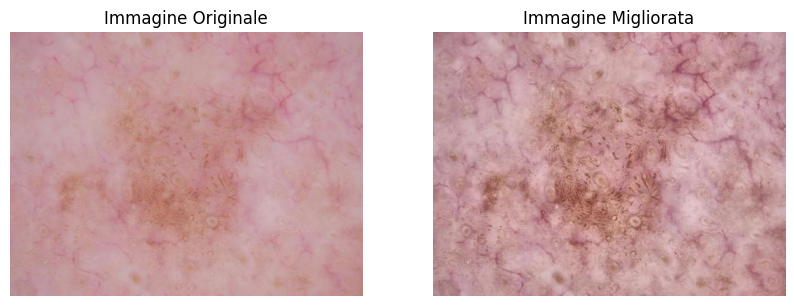

In [ ]:

image = cv2.imread('/content/dataset/organized/bkl/ISIC_0028830.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_enhanced = clahe.apply(l)

lab_enhanced = cv2.merge([l_enhanced, a, b])

enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Immagine Originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Immagine Migliorata")
plt.axis("off")

plt.show()

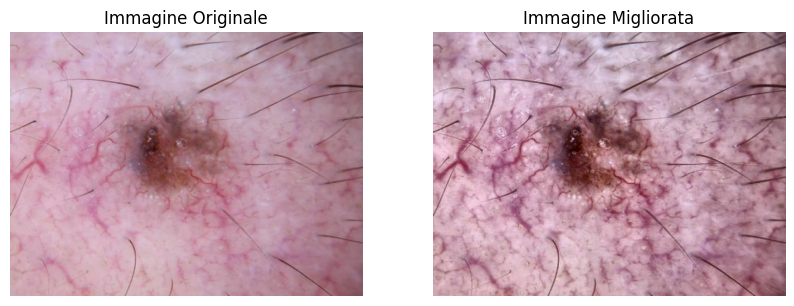

In [ ]:
image = cv2.imread('/content/dataset/organized/bcc/ISIC_0032307.jpg')


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_enhanced = clahe.apply(l)
lab_enhanced = cv2.merge([l_enhanced, a, b])

enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Immagine Originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Immagine Migliorata")
plt.axis("off")

plt.show()

## **Rebalanced the dataset**

In [ ]:
class_counts = {classe: np.sum(labels == classe) for classe in np.unique(labels)}
max_samples = max(class_counts.values())

In [ ]:

print("\nDistribuzione originale delle classi:")
for classe in selected_classes:
    count = np.sum(labels == classe)
    print(f"{classe}: {count}")


target_samples = 514
balanced_images = []
balanced_labels = []

for class_name in selected_classes:
    class_indices = np.where(labels == class_name)[0]
    n_samples = len(class_indices)

    print(f"\nBilanciamento classe {class_name}: {n_samples} -> {target_samples}")

    if n_samples > target_samples:
        selected_indices = np.random.choice(class_indices, target_samples, replace=False)
        balanced_images.extend(enhanced_images[selected_indices])
        balanced_labels.extend([class_name] * target_samples)
    else:
        balanced_images.extend(enhanced_images[class_indices])
        balanced_labels.extend([class_name] * n_samples)

balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

print("\nDistribuzione finale delle classi:")
for classe in selected_classes:
    count = np.sum(balanced_labels == classe)
    print(f"{classe}: {count}")

print(f"\nDataset bilanciato: {len(balanced_images)} immagini totali")
print(f"Shape delle immagini: {balanced_images.shape}")



Distribuzione originale delle classi:
bcc: 514
bkl: 1099
mel: 1113
nv: 6705

Bilanciamento classe bcc: 514 -> 514

Bilanciamento classe bkl: 1099 -> 514

Bilanciamento classe mel: 1113 -> 514

Bilanciamento classe nv: 6705 -> 514

Distribuzione finale delle classi:
bcc: 514
bkl: 514
mel: 514
nv: 514

Dataset bilanciato: 2056 immagini totali
Shape delle immagini: (2056, 224, 224, 3)


## **Split training and test set**

In [ ]:
val_size = 0.15
test_size = 0.15

X_temp, X_test, y_temp, y_test = train_test_split(
    balanced_images,
    balanced_labels,
    test_size=test_size,
    stratify=balanced_labels,
    random_state=42
)


val_adjusted_size = val_size / (1 - test_size)

# validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=val_adjusted_size,
    stratify=y_temp,
    random_state=42
)

## **Label encoding and data augmentation**

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(balanced_labels))
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes)


# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    horizontal_flip= True,
    zoom_range= 0.2,
    fill_mode='nearest'
)

# Generator for validation and testing (rescaling only)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(
    X_train, y_train_categorical,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val, y_val_categorical,
    batch_size=32
)

test_generator = val_datagen.flow(
    X_test, y_test_categorical,
    batch_size=32
)


## **Models from the scratch**

### Model1

In [ ]:
# CNN
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

input_shape = X_train.shape[1:]

# Create and compile
model = create_cnn_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluation sul test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 448ms/step - accuracy: 0.3843 - loss: 25.8661 - val_accuracy: 0.2492 - val_loss: 29.5102 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.3870 - loss: 4.2528 - val_accuracy: 0.2524 - val_loss: 42.7935 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.4130 - loss: 1.5402 - val_accuracy: 0.2524 - val_loss: 32.2786 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.3906 - loss: 1.3078 - val_accuracy: 0.2589 - val_loss: 25.9225 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.4082 - loss: 1.2771 - val_accuracy: 0.3042 - val_loss: 9.6285 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.4669 - loss: 1.2191 - val_accuracy: 0.2654 - val_loss: 4.4294 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.4651 - los

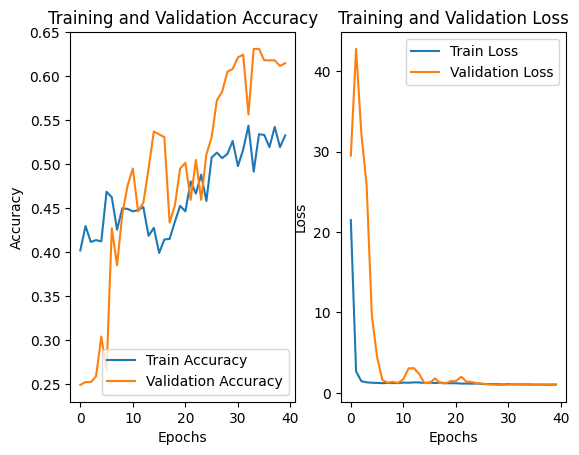

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


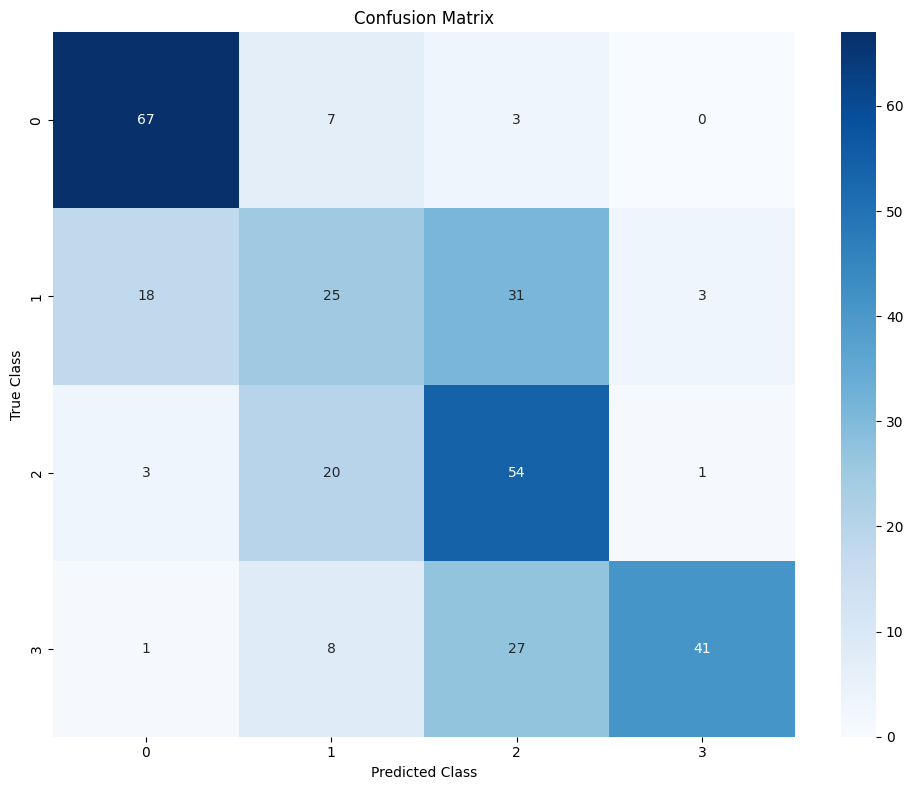


Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81        77
         1.0       0.42      0.32      0.36        77
         2.0       0.47      0.69      0.56        78
         3.0       0.91      0.53      0.67        77

    accuracy                           0.61       309
   macro avg       0.64      0.60      0.60       309
weighted avg       0.64      0.61      0.60       309



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_generator.reset()

y_true = np.array([])
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true = np.append(y_true, np.argmax(labels, axis=1))

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.tight_layout()


plt.show()
print(classification_report(y_true, y_pred))

In [ ]:
save_path = '/content/drive/MyDrive/Image classification Project/my_model.h5'

os.makedirs(os.path.dirname(save_path), exist_ok=True)
 model.save(save_path)


Modello salvato in: /content/drive/MyDrive/Image classification Project/my_model.h5
